In [2]:
import os
import pandas as pd

project_root = os.path.abspath(os.path.join(os.getcwd(),".."))

# Build absolute paths to the CSV files
deepseek = os.path.join(project_root, 'Data Augmentation/deepseek_generation.csv')
gemini = os.path.join(project_root, 'Data Augmentation/Gemini_generation.csv')
gpt = os.path.join(project_root,'Data Augmentation/GPT_generation.csv')
grok = os.path.join(project_root,'Data Augmentation/Grok_generation.csv')

deepseek_df = pd.read_csv(deepseek)
gemini_df = pd.read_csv(gemini)
gpt_df = pd.read_csv(gpt)
grok_df = pd.read_csv(grok)


In [3]:
print("Gemini duplicates: ",gemini_df.duplicated().sum())
print("Deepseek duplicates: ",deepseek_df.duplicated().sum())
print("GPT duplicates: ",gpt_df.duplicated().sum())
print("Grok duplicates: ",grok_df.duplicated().sum())

Gemini duplicates:  1
Deepseek duplicates:  2
GPT duplicates:  1
Grok duplicates:  34


## Self Bleu Score and Repetition Rate

In [4]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import Counter
import itertools

def ngram_repeat_score(texts, n=2):
    all_ngrams = []
    for text in texts:
        tokens = str(text).split()
        ngrams = list(zip(*[tokens[i:] for i in range(n)]))
        all_ngrams.extend(ngrams)
    if not all_ngrams:
        return 0.0
    ngram_counts = Counter(all_ngrams)
    repeated = sum([count for count in ngram_counts.values() if count > 1])
    return repeated / len(all_ngrams)

def calculate_self_bleu(texts):
    scores = []
    smoothing = SmoothingFunction().method1
    for i, candidate in enumerate(texts):
        references = [str(t).split() for j, t in enumerate(texts) if j != i]
        if not references:
            continue
        score = sentence_bleu(references, str(candidate).split(), smoothing_function=smoothing)
        scores.append(score)
    return np.mean(scores) if scores else 0.0

# Collect metrics for each model
results = []
for df, name in [
    (gemini_df, "Gemini"),
    (deepseek_df, "Deepseek"),
    (gpt_df, "GPT"),
    (grok_df, "Grok")
]:
    comments = df[df.columns[0]].dropna().astype(str).tolist()
    bleu = calculate_self_bleu(comments)
    ngram_score = ngram_repeat_score(comments, n=2)
    results.append({"Model": name, "Self-BLEU": bleu, "Repeat Score": ngram_score})

metrics_df = pd.DataFrame(results)
metrics_df

,Model,Self-BLEU,Repeat Score
0,Gemini,0.461101,0.564074
1,Deepseek,0.659844,0.729249
2,GPT,0.875245,0.907056
3,Grok,0.808677,0.850041


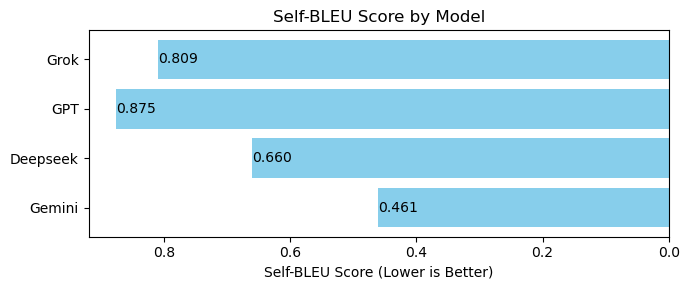

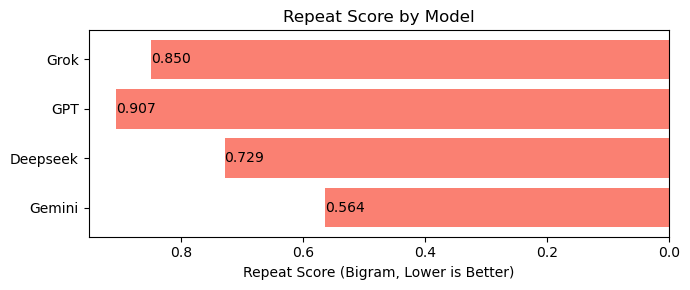

In [13]:
import matplotlib.pyplot as plt

# Plot Self-BLEU Score (horizontal bar, lower is better)
plt.figure(figsize=(7, 3))
plt.barh(metrics_df['Model'], metrics_df['Self-BLEU'], color='skyblue')
plt.xlabel('Self-BLEU Score (Lower is Better)')
plt.title('Self-BLEU Score by Model')
plt.gca().invert_xaxis()  # Lower is better, so invert axis
for i, v in enumerate(metrics_df['Self-BLEU']):
    plt.text(v, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()

# Plot Repeat Score (horizontal bar, lower is better)
plt.figure(figsize=(7, 3))
plt.barh(metrics_df['Model'], metrics_df['Repeat Score'], color='salmon')
plt.xlabel('Repeat Score (Bigram, Lower is Better)')
plt.title('Repeat Score by Model')
plt.gca().invert_xaxis()  # Lower is better, so invert axis
for i, v in enumerate(metrics_df['Repeat Score']):
    plt.text(v, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()

In [3]:
gemini_full_path = os.path.join(project_root,'Data Augmentation/Gemini_augmented_data.csv')

gemini_full = pd.read_csv(gemini_full_path)

In [7]:
results = []
for df, name in [
    (gemini_full, "Gemini full"),
]:
    comments = df[df.columns[0]].dropna().astype(str).tolist()
    bleu = calculate_self_bleu(comments)
    ngram_score = ngram_repeat_score(comments, n=3)
    results.append({"Model": name, "Self-BLEU": bleu, "Repeat Score": ngram_score})
